In [3]:
#%pip install "numpy>=1.16.5,<1.23.0"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import requests
import json
import folium
from folium.plugins import MarkerCluster
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score

# **Read and clean the data**

https://www.kaggle.com/datasets/borapajo/food-choices

In [2]:
food_choices_df = pd.read_csv('/kaggle/input/food-choices/food_coded.csv')

# Check the column names
print("Column names:", food_choices_df.columns)

# Perform data cleaning and extract relevant features
relevant_features = ['cook', 'eating_out', 'on_off_campus']

# Check if the relevant features exist in the DataFrame before extracting
if all(col in food_choices_df.columns for col in relevant_features):
    food_data = food_choices_df[relevant_features].dropna()
else:
    print("Error: One or more relevant features not found in the DataFrame.")
    
food_data = food_data.reset_index(drop=True)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/food-choices/food_coded.csv'

In [ ]:
#food_data.shape
food_data.head(5)

,cook,eating_out,on_off_campus
0,2.0,3,1.0
1,3.0,2,1.0
2,1.0,2,2.0
3,2.0,2,1.0
4,1.0,2,1.0


In [ ]:
# Define a mapping from old values to new values for the "cook" feature
cook_value_mapping = {1: 5, 2: 4, 3: 3, 4: 2, 5: 1}

# Interchange the values only for the "cook" feature
food_data['cook'] = [cook_value_mapping[value] for value in food_data['cook']]

# Print the updated dataset
print(food_data)

     cook  eating_out  on_off_campus
0       4           3            1.0
1       3           2            1.0
2       5           2            2.0
3       4           2            1.0
4       5           2            1.0
..    ...         ...            ...
116     4           2            1.0
117     3           2            3.0
118     3           4            1.0
119     3           3            1.0
120     3           5            1.0

[121 rows x 3 columns]


In [ ]:
# Data Transformation: Scale the data using StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(food_data)

# Convert the NumPy array to a Pandas DataFrame
food_scaled_data = pd.DataFrame(scaled, columns=['cook', 'eating_out', 'on_off_campus'])
food_scaled_data.head()

,cook,eating_out,on_off_campus
0,0.756258,0.381747,-0.482594
1,-0.206976,-0.523966,-0.482594
2,1.719492,-0.523966,0.977252
3,0.756258,-0.523966,-0.482594
4,1.719492,-0.523966,-0.482594


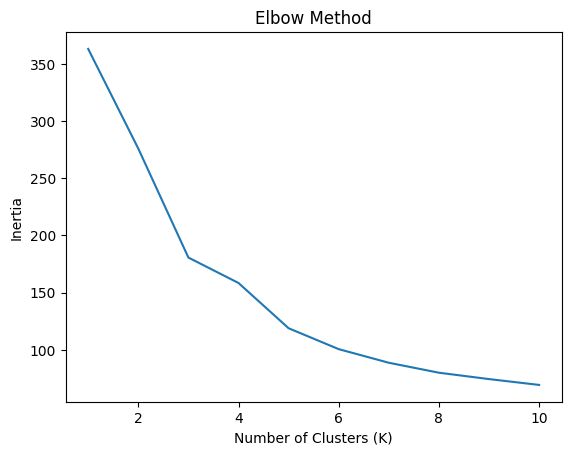

In [ ]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
    kmeans.fit(food_scaled_data)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

For n_clusters = 3 The average silhouette_score is : 0.36443099848960464
For n_clusters = 4 The average silhouette_score is : 0.3976330908505974
For n_clusters = 6 The average silhouette_score is : 0.3918143066276567


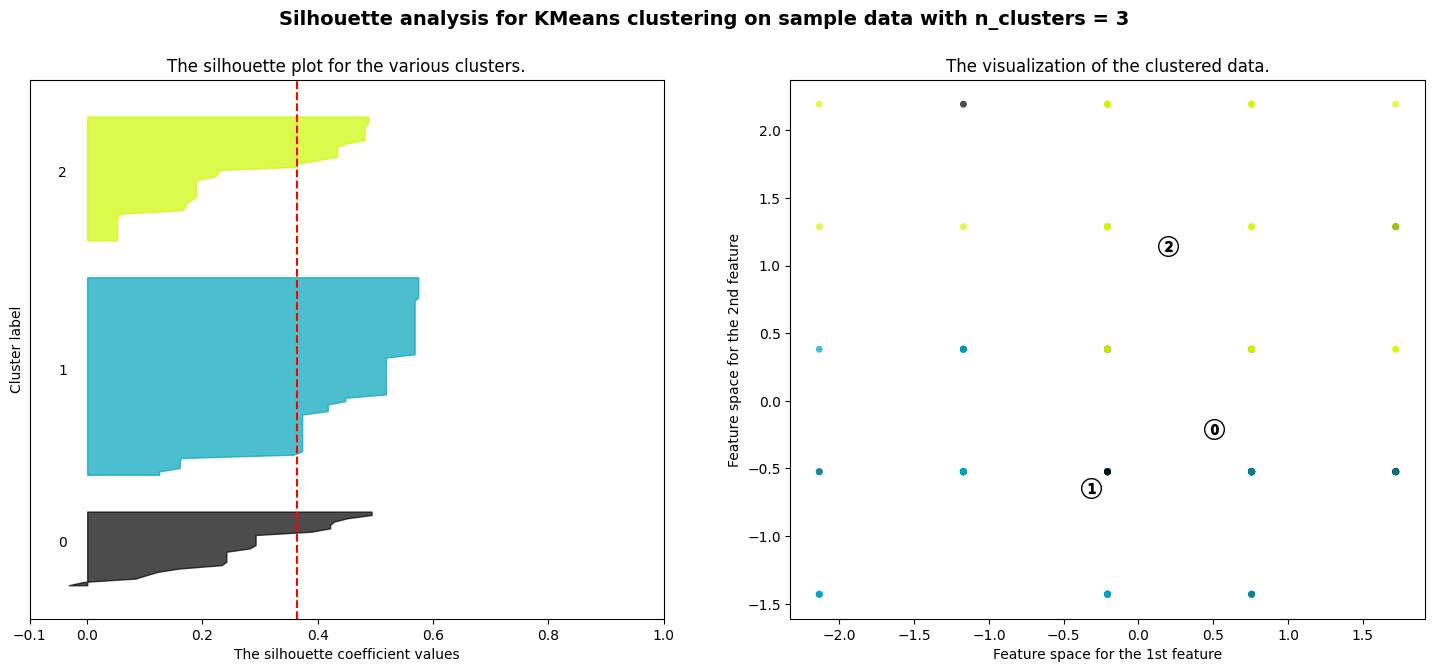

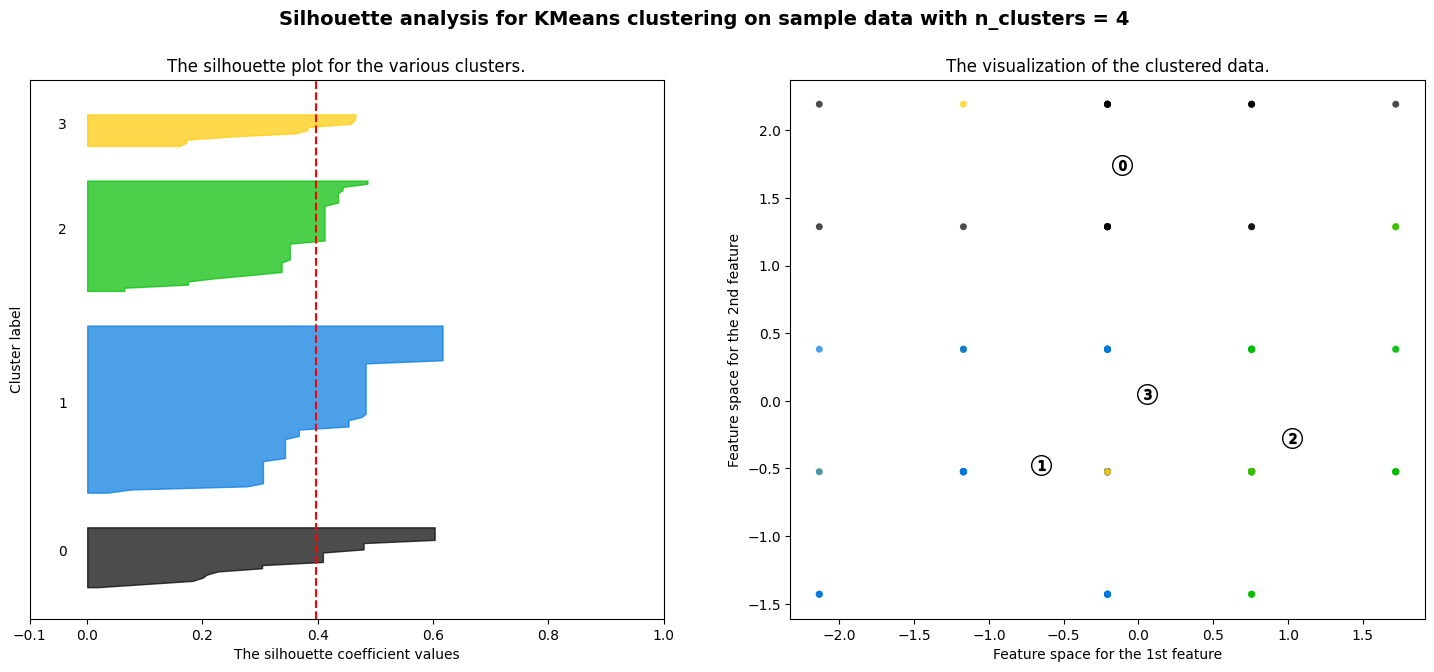

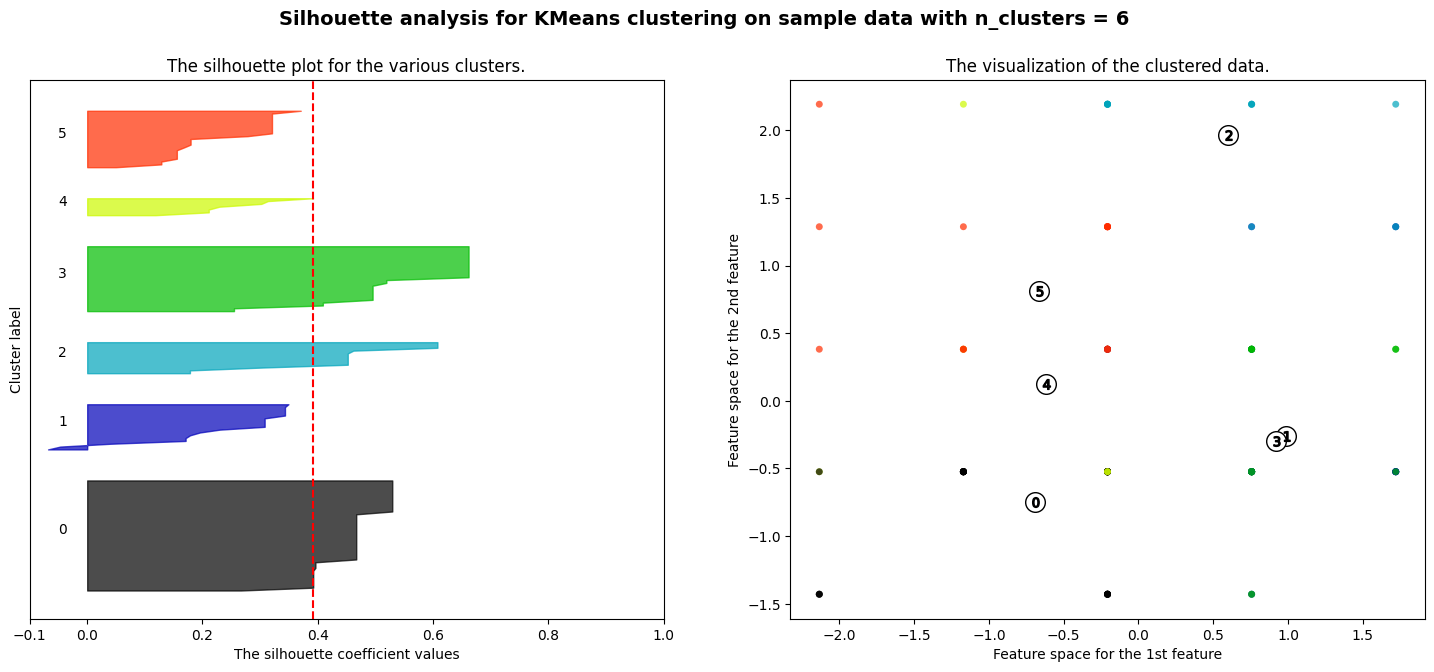

In [ ]:
range_n_clusters = [3,4,6]
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(food_scaled_data) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10, n_init=10)
    cluster_labels = clusterer.fit_predict(food_scaled_data)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(food_scaled_data, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(food_scaled_data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(food_scaled_data.iloc[:, 0], food_scaled_data.iloc[:, 1], marker='.', s=100, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

# K-means Clustering

In [ ]:
# Perform K-Means Clustering
num_clusters = 4  # You can choose the number of clusters based on the elbow method or domain knowledge
kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init='auto')

labels = kmeans.fit_predict(food_scaled_data)

**Silhouette Score for kmeans clustering**

In [ ]:
silhouette_score(food_scaled_data,labels)

0.38306187640032824

# Hierarchical Clustering

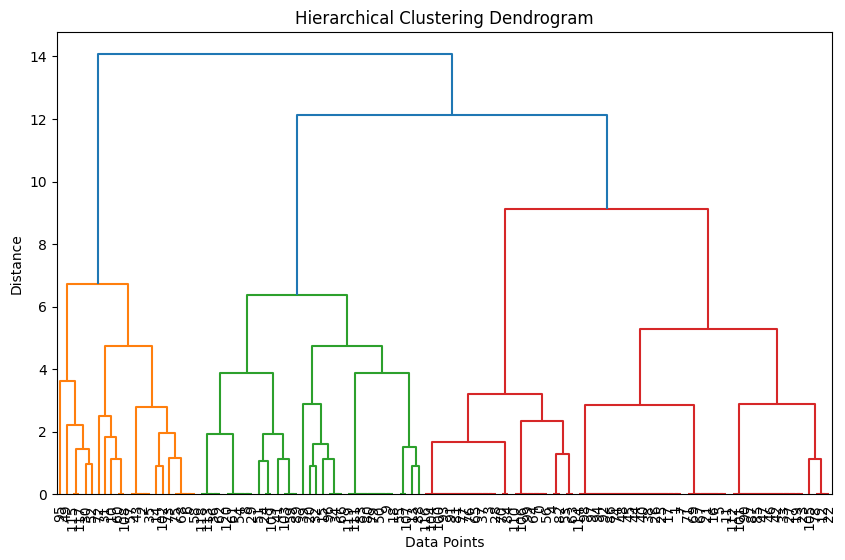

In [ ]:
linkage_matrix = linkage(food_scaled_data.values, method='ward', metric='euclidean')

# Plot dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, labels=np.arange(len(food_scaled_data)), leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

In [ ]:
cluster = AgglomerativeClustering(n_clusters=4, metric="euclidean", linkage="ward")
cl = cluster.fit_predict(food_scaled_data)

In [ ]:
silhouette_score(food_scaled_data,cl)

0.349132188580147

# DBSCAN

In [ ]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(food_scaled_data)
distances, indices = nbrs.kneighbors(food_scaled_data)

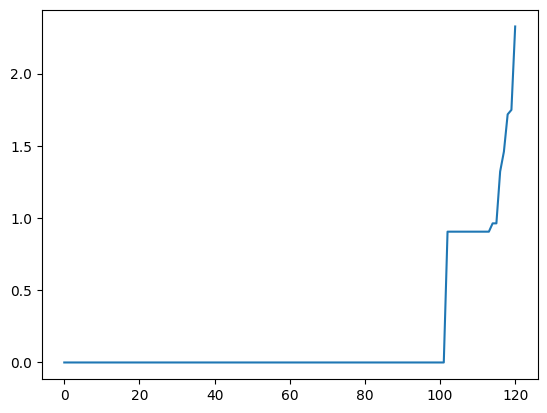

In [ ]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [ ]:
dbscancluster = DBSCAN(eps=1, min_samples=5)
dbscancluster.fit(food_scaled_data)
clusters = dbscancluster.labels_

In [ ]:
len(set(clusters))

4

In [ ]:
silhouette_score(food_scaled_data,clusters)

0.2585093695453152

**Perform K-Means Clustering**

In [ ]:
# Perform K-Means Clustering
num_clusters = 4  # You can choose the number of clusters based on the elbow method or domain knowledge
kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init='auto')
labels = kmeans.fit_predict(food_scaled_data)
food_data['cluster'] = labels

food_data.head(10)
#food_data.info()

,cook,eating_out,on_off_campus,cluster
0,4,3,1.0,0
1,3,2,1.0,0
2,5,2,2.0,3
3,4,2,1.0,0
4,5,2,1.0,3
5,3,1,1.0,0
6,4,2,2.0,3
7,3,2,1.0,0
8,3,5,1.0,1
9,3,3,1.0,0


In [ ]:
features = ['cook', 'eating_out', 'on_off_campus']

# Cluster Interpretation
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_interpretation = pd.DataFrame(cluster_centers, columns=features)

# Display Cluster Interpretation
print("Cluster Interpretation based on Mean Values of Features:")
print(cluster_interpretation)

Cluster Interpretation based on Mean Values of Features:
       cook  eating_out  on_off_campus
0  2.931507    2.082192       1.013699
1  3.421053    4.473684       1.052632
2  2.545455    3.181818       2.818182
3  4.555556    2.222222       2.000000


In [ ]:
# Step 1: Calculate the mean of the specific feature for each cluster
cluster_centers = food_data.groupby('cluster').mean()

# Step 2: Order the clusters based on the mean of the specific feature
ordered_clusters = cluster_centers.sort_values(by='on_off_campus').index

# Step 3: Create a mapping from the original cluster labels to the new ordered labels
cluster_mapping = {old_label: new_label for new_label, old_label in enumerate(ordered_clusters)}

# Step 4: Apply this mapping to your data
food_data['Ordered_Cluster'] = food_data['cluster'].replace(cluster_mapping)

# Drop the original 'Cluster' column
food_data.drop(columns=['cluster'], axis=1, inplace=True)

#Rename the 'Ordered_Cluster' column to 'Cluster'
food_data = food_data.rename(columns={'Ordered_Cluster': 'cluster'})

print(food_data)

     cook  eating_out  on_off_campus  cluster
0       4           3            1.0        0
1       3           2            1.0        0
2       5           2            2.0        2
3       4           2            1.0        0
4       5           2            1.0        2
..    ...         ...            ...      ...
116     4           2            1.0        0
117     3           2            3.0        3
118     3           4            1.0        1
119     3           3            1.0        0
120     3           5            1.0        1

[121 rows x 4 columns]


In [ ]:
# Calculate the new cluster centers based on the ordered labels
new_cluster_centers = food_data.groupby('cluster').mean()

print(new_cluster_centers)

             cook  eating_out  on_off_campus
cluster                                     
0        2.931507    2.082192       1.013699
1        3.421053    4.473684       1.052632
2        4.555556    2.222222       2.000000
3        2.545455    3.181818       2.818182


### EDA

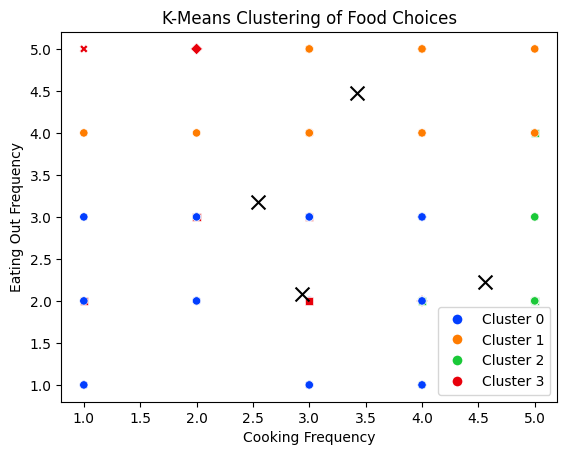

In [ ]:
# Add Legends
legend_elements = []
for i in range(num_clusters):
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label='Cluster ' + str(i),
                                      markerfacecolor=sns.color_palette('bright', num_clusters)[i], markersize=8))

# Visualize the clusters
sns.scatterplot(x='cook', y='eating_out', hue='cluster', palette=sns.color_palette('bright', num_clusters),
                data=food_data, style='on_off_campus', markers=["o", "X", "s", "D"])
plt.scatter(new_cluster_centers.iloc[:, 0],new_cluster_centers.iloc[:, 1], marker='x', color='black', s=100, label='Cluster Centers')
plt.legend(handles=legend_elements)
plt.xlabel("Cooking Frequency")
plt.ylabel("Eating Out Frequency")
plt.title("K-Means Clustering of Food Choices")
plt.show()

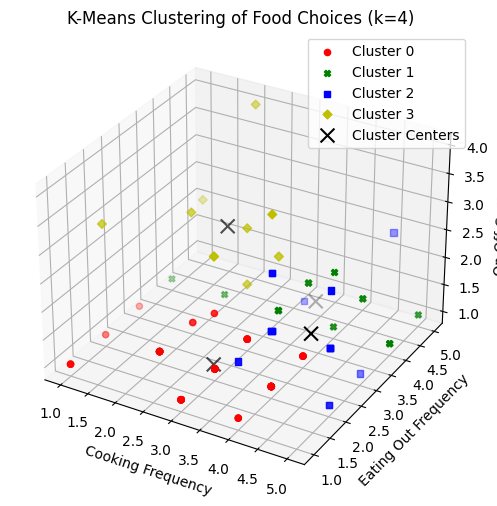

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
# 3D Plot of the Clusters
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot data points for each cluster with different colors and markers
colors = ['r', 'g', 'b','y']
markers = ['o', 'X', 's','D']
for cluster_num in range(4):
    cluster_data = food_data[food_data['cluster'] == cluster_num]
    ax.scatter(cluster_data['cook'], cluster_data['eating_out'], cluster_data['on_off_campus'],
               c=colors[cluster_num], marker=markers[cluster_num], label='Cluster ' + str(cluster_num))

# Plot cluster centers
ax.scatter(new_cluster_centers.iloc[:, 0], new_cluster_centers.iloc[:, 1], new_cluster_centers.iloc[:, 2], c='black', marker='x', s=100,
           label='Cluster Centers')

# Set labels and title
ax.set_xlabel("Cooking Frequency")
ax.set_ylabel("Eating Out Frequency")
ax.set_zlabel("On Off Campus")
ax.set_title("K-Means Clustering of Food Choices (k=4)")

# Add legend
ax.legend()

plt.show()

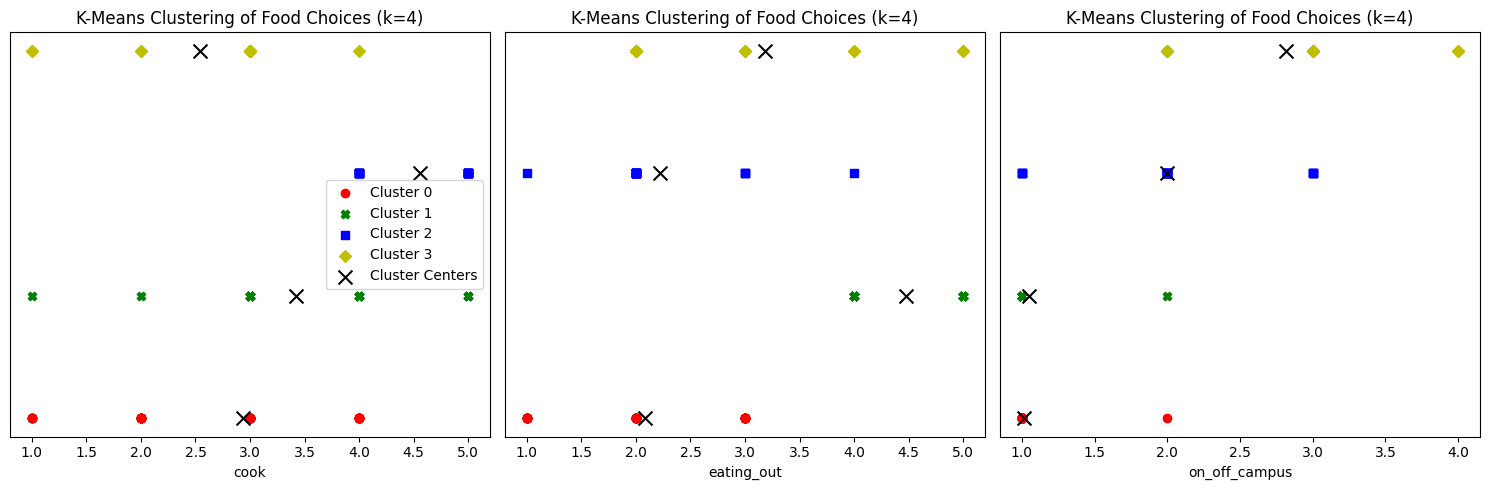

In [ ]:
# Plotting clusters for each feature in separate subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
colors = ['r', 'g', 'b','y']  # Use different colors for each cluster
markers = ['o', 'X', 's','D']  # Use different markers for each cluster

for i, feature in enumerate(features):
    ax = axes[i]
    for cluster_num in range(4):
        cluster_data = food_data[food_data['cluster'] == cluster_num]
        ax.scatter(cluster_data[feature], cluster_data['cluster'],
                   c=colors[cluster_num], marker=markers[cluster_num], label='Cluster ' + str(cluster_num))
    ax.scatter(new_cluster_centers.iloc[:, i], [0, 1, 2, 3], c='black', marker='x', s=100,
               label='Cluster Centers')
    ax.set_xlabel(feature)
    ax.set_yticks([])
    ax.set_title("K-Means Clustering of Food Choices (k=4)")

axes[0].legend()
plt.tight_layout()
plt.show()

## Retrieve location data from Foursquare API

In [ ]:
url = "https://api.foursquare.com/v3/places/search"

params = {
    "ll": "11.0383,77.0373",
    "radius":10000, 
    "categories":"12122,19013,19016", 
    "fields":"fsq_id,name,geocodes,location,categories,distance", 
    "limit":50, 
    "sort":"DISTANCE"
}

headers = {
    "Accept": "application/json",
    "Authorization": "fsq3kk7EeflajsXGlyeIMLcZ5BOnI/Ru8eYFNlmwto1BSpw="
}

response = requests.request("GET", url, params=params, headers=headers).json()

#print(response.text)

In [ ]:
nearby_venues = pd.json_normalize(response['results'])
nearby_venues.head()

,fsq_id,categories,distance,name,geocodes.main.latitude,geocodes.main.longitude,location.address,location.country,location.formatted_address,location.locality,location.postcode,location.region,location.address_extended,geocodes.roof.latitude,geocodes.roof.longitude,geocodes.drop_off.latitude,geocodes.drop_off.longitude,location.cross_street
0,33ef9eb598f04f8bcb041d3e,"[{'id': 19013, 'name': 'Hostel', 'short_name':...",110,Chitra Sri Venkatachalapathy Mansion Ladies Ho...,11.038427,77.038309,Avinashi Road,IN,"Avinashi Road, Coimbatore 641014, Tamil Nadu",Coimbatore,641014,Tamil Nadu,NaN,NaN,NaN,NaN,NaN,NaN
1,cecf1f45543d41232660841e,"[{'id': 19013, 'name': 'Hostel', 'short_name':...",434,Tulips Ladies Girls Womens Hostel,11.039175,77.041183,"Door No 25, Street Number 1, Avinashi Main Road",IN,"Door No 25, Street Number 1, Avinashi Main Roa...",Coimbatore,641014,Tamil Nadu,"Opposite Kmch, Madhusudhan Layout, Shastri",NaN,NaN,NaN,NaN,NaN
2,98d8a97d5d5e4040dba98865,"[{'id': 19013, 'name': 'Hostel', 'short_name':...",676,Bharathi Hostel,11.032426,77.035685,"Psg Cas, Civil Aerodrome Post, Peelamedu",IN,"Psg Cas, Civil Aerodrome Post, Peelamedu, Coim...",Coimbatore,641014,Tamil Nadu,NaN,NaN,NaN,NaN,NaN,NaN
3,a26a37d74b534e99b34d2b6a,"[{'id': 19013, 'name': 'Hostel', 'short_name':...",715,Vishaka PG Boys Hostel,11.034668,77.042717,NaN,IN,"Coimbatore 641014, Tamil Nadu",Coimbatore,641014,Tamil Nadu,NaN,11.034668,77.042717,NaN,NaN,NaN
4,86717c8a460546c0ae9d6af9,"[{'id': 19013, 'name': 'Hostel', 'short_name':...",818,Ambal Ladies Hostel,11.043492,77.042618,NaN,IN,"Coimbatore 641014, Tamil Nadu",Coimbatore,641014,Tamil Nadu,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
nearby_venues.columns

Index(['fsq_id', 'categories', 'distance', 'name', 'geocodes.main.latitude',
       'geocodes.main.longitude', 'location.address', 'location.country',
       'location.formatted_address', 'location.locality', 'location.postcode',
       'location.region', 'location.address_extended',
       'geocodes.roof.latitude', 'geocodes.roof.longitude',
       'geocodes.drop_off.latitude', 'geocodes.drop_off.longitude',
       'location.cross_street'],
      dtype='object')

In [ ]:
# Select the desired columns
selected_columns = ['name', 'categories', 'geocodes.main.latitude', 'geocodes.main.longitude', 'distance']

"""# Check for null values in the specified columns
null_counts = nearby_venues[selected_columns].isnull().sum()

# Display the count of null values for each column
print(null_counts)"""


location_data = nearby_venues.loc[:, selected_columns]

# Rename the columns
location_data.rename(columns={'geocodes.main.latitude': 'lat', 'geocodes.main.longitude': 'lon'}, inplace=True)

# Display the updated DataFrame
location_data.head(15)

,name,categories,lat,lon,distance
0,Chitra Sri Venkatachalapathy Mansion Ladies Ho...,"[{'id': 19013, 'name': 'Hostel', 'short_name':...",11.038427,77.038309,110
1,Tulips Ladies Girls Womens Hostel,"[{'id': 19013, 'name': 'Hostel', 'short_name':...",11.039175,77.041183,434
2,Bharathi Hostel,"[{'id': 19013, 'name': 'Hostel', 'short_name':...",11.032426,77.035685,676
3,Vishaka PG Boys Hostel,"[{'id': 19013, 'name': 'Hostel', 'short_name':...",11.034668,77.042717,715
4,Ambal Ladies Hostel,"[{'id': 19013, 'name': 'Hostel', 'short_name':...",11.043492,77.042618,818
5,PG Hostel,"[{'id': 19013, 'name': 'Hostel', 'short_name':...",11.030020,77.036450,924
6,Snr Sons College Hostel For Women,"[{'id': 19013, 'name': 'Hostel', 'short_name':...",11.031382,77.044100,1068
7,Baba Ladies Hostel,"[{'id': 19013, 'name': 'Hostel', 'short_name':...",11.028906,77.034978,1074
8,Vijay Mansion Gents Hostel,"[{'id': 19013, 'name': 'Hostel', 'short_name':...",11.033245,77.027681,1190
9,Sri Muthu House,"[{'id': 19016, 'name': 'Lodge', 'short_name': ...",11.033269,77.027572,1199


In [ ]:
# Create a map centered at a specific location (for example, Bangalore, India)
map_location = folium.Map(location=[11.0168, 76.9558], tiles='cartodbpositron', zoom_start=12)

# Add markers for each location
for _, row in location_data.iterrows():
    lat, lon = row['lat'], row['lon']
    name = row['name']
    folium.Marker(location=[lat, lon], popup=name).add_to(map_location)

# Display the map
map_location

## Analyzing nearby venues

In [ ]:
GroceryList=[]
ResList=[]
latitudes = list(location_data['lat'])
longitudes = list( location_data['lon'])
for lat, lng in zip(latitudes, longitudes):
    url = "https://api.foursquare.com/v3/places/search"
    
    params = {
    "ll": "{},{}".format(lat,lng),
    "radius":1000, 
    "categories":"13199", 
    "fields":"fsq_id,name,geocodes,location,categories,distance", 
    "limit":50, 
    "sort":"DISTANCE"
    }
    
    headers = {
    "Accept": "application/json",
    "Authorization": "fsq3kk7EeflajsXGlyeIMLcZ5BOnI/Ru8eYFNlmwto1BSpw="
    }
    
    response = requests.request("GET", url, params=params, headers=headers).json()
    restaurants = pd.json_normalize(response['results'])
    ResList.append(len(restaurants.index))
    
    
    url = "https://api.foursquare.com/v3/places/search"
    
    params = {
    "ll": "{},{}".format(lat,lng),
    "radius":2000, 
    "categories":"17033,17057,17142,17144", 
    "fields":"fsq_id,name,geocodes,location,categories,distance", 
    "limit":50, 
    "sort":"DISTANCE"
    }
    
    headers = {
    "Accept": "application/json",
    "Authorization": "fsq3kk7EeflajsXGlyeIMLcZ5BOnI/Ru8eYFNlmwto1BSpw="
    }
    
    response = requests.request("GET", url, params=params, headers=headers).json()
    groceries = pd.json_normalize(response['results'])
    GroceryList.append(len(groceries.index))
    
location_data['Restaurants Count'] = ResList
location_data['Groceries Count'] = GroceryList
location_data.head(10)

,name,categories,lat,lon,distance,Restaurants Count,Groceries Count
0,Chitra Sri Venkatachalapathy Mansion Ladies Ho...,"[{'id': 19013, 'name': 'Hostel', 'short_name':...",11.038427,77.038309,110,21,13
1,Tulips Ladies Girls Womens Hostel,"[{'id': 19013, 'name': 'Hostel', 'short_name':...",11.039175,77.041183,434,21,13
2,Bharathi Hostel,"[{'id': 19013, 'name': 'Hostel', 'short_name':...",11.032426,77.035685,676,19,16
3,Vishaka PG Boys Hostel,"[{'id': 19013, 'name': 'Hostel', 'short_name':...",11.034668,77.042717,715,22,13
4,Ambal Ladies Hostel,"[{'id': 19013, 'name': 'Hostel', 'short_name':...",11.043492,77.042618,818,16,11
5,PG Hostel,"[{'id': 19013, 'name': 'Hostel', 'short_name':...",11.030020,77.036450,924,16,18
6,Snr Sons College Hostel For Women,"[{'id': 19013, 'name': 'Hostel', 'short_name':...",11.031382,77.044100,1068,14,12
7,Baba Ladies Hostel,"[{'id': 19013, 'name': 'Hostel', 'short_name':...",11.028906,77.034978,1074,12,19
8,Vijay Mansion Gents Hostel,"[{'id': 19013, 'name': 'Hostel', 'short_name':...",11.033245,77.027681,1190,7,21
9,Sri Muthu House,"[{'id': 19016, 'name': 'Lodge', 'short_name': ...",11.033269,77.027572,1199,7,21


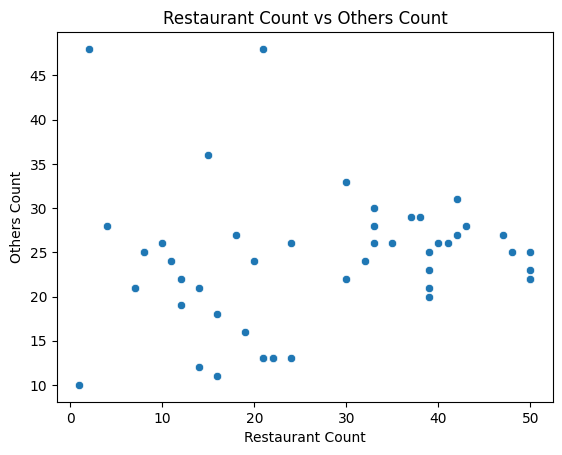

In [ ]:
# Scatter plot
sns.scatterplot(x='Restaurants Count', y='Groceries Count', data=location_data)
plt.xlabel('Restaurant Count')
plt.ylabel('Others Count')
plt.title('Restaurant Count vs Others Count')
plt.show()

In [ ]:
relevant_features = ['Restaurants Count','Groceries Count','distance']
cluster_data = location_data.loc[:, relevant_features]
cluster_data.head(10)

,Restaurants Count,Groceries Count,distance
0,21,13,110
1,21,13,434
2,19,16,676
3,22,13,715
4,16,11,818
5,16,18,924
6,14,12,1068
7,12,19,1074
8,7,21,1190
9,7,21,1199


In [ ]:
# Data Transformation: Scale the data using StandardScaler
scaler = StandardScaler()
location_scaled = scaler.fit_transform(cluster_data)

location_scaled_data = pd.DataFrame(location_scaled, columns=relevant_features)

In [ ]:
location_scaled_data.head(5)

,Restaurants Count,Groceries Count,distance
0,-0.385568,-1.415043,-2.023221
1,-0.385568,-1.415043,-1.801621
2,-0.523764,-1.022702,-1.636105
3,-0.316470,-1.415043,-1.609431
4,-0.731058,-1.676604,-1.538984


## Perform K-Means Clustering on Location data

In [ ]:
# Perform K-Means Clustering
num_clusters = 4  # You can choose the number of clusters based on the elbow method or domain knowledge
kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init='auto')
labels = kmeans.fit_predict(location_scaled_data)
cluster_data['cluster'] = labels
location_data['cluster'] = labels

In [ ]:
cluster_data.head(5)

,Restaurants Count,Groceries Count,distance,cluster
0,21,13,110,2
1,21,13,434,2
2,19,16,676,2
3,22,13,715,2
4,16,11,818,2


In [ ]:
# Step 1: Calculate the mean of the specific feature for each cluster
cluster_centers = cluster_data.groupby('cluster').mean()

# Step 2: Order the clusters based on the mean of the specific feature
ordered_clusters = cluster_centers.sort_values(by='distance').index

# Step 3: Create a mapping from the original cluster labels to the new ordered labels
cluster_mapping = {old_label: new_label for new_label, old_label in enumerate(ordered_clusters)}

# Step 4: Apply this mapping to your data
cluster_data['Ordered_Cluster'] = cluster_data['cluster'].replace(cluster_mapping)

# Drop the original 'Cluster' column
cluster_data.drop(columns=['cluster'], axis=1, inplace=True)

#Rename the 'Ordered_Cluster' column to 'Cluster'
cluster_data = cluster_data.rename(columns={'Ordered_Cluster': 'cluster'})

cluster_data.head()

,Restaurants Count,Groceries Count,distance,cluster
0,21,13,110,0
1,21,13,434,0
2,19,16,676,0
3,22,13,715,0
4,16,11,818,0


In [ ]:
# Calculate the new cluster centers based on the ordered labels
new_cluster_centers = cluster_data.groupby('cluster').mean()

print(new_cluster_centers)

         Restaurants Count  Groceries Count     distance
cluster                                                 
0                15.090909        16.454545   882.545455
1                30.500000        26.000000  2523.750000
2                41.105263        26.736842  3525.789474
3                11.500000        24.500000  4709.916667


In [ ]:
location_data.head(5)

,name,categories,lat,lon,distance,Restaurants Count,Groceries Count,cluster
0,Chitra Sri Venkatachalapathy Mansion Ladies Ho...,"[{'id': 19013, 'name': 'Hostel', 'short_name':...",11.038427,77.038309,110,21,13,2
1,Tulips Ladies Girls Womens Hostel,"[{'id': 19013, 'name': 'Hostel', 'short_name':...",11.039175,77.041183,434,21,13,2
2,Bharathi Hostel,"[{'id': 19013, 'name': 'Hostel', 'short_name':...",11.032426,77.035685,676,19,16,2
3,Vishaka PG Boys Hostel,"[{'id': 19013, 'name': 'Hostel', 'short_name':...",11.034668,77.042717,715,22,13,2
4,Ambal Ladies Hostel,"[{'id': 19013, 'name': 'Hostel', 'short_name':...",11.043492,77.042618,818,16,11,2


In [ ]:
location_data.drop(columns=['Restaurants Count','Groceries Count','distance','cluster'], axis=1, inplace=True)
location_data.head()

,name,categories,lat,lon
0,Chitra Sri Venkatachalapathy Mansion Ladies Ho...,"[{'id': 19013, 'name': 'Hostel', 'short_name':...",11.038427,77.038309
1,Tulips Ladies Girls Womens Hostel,"[{'id': 19013, 'name': 'Hostel', 'short_name':...",11.039175,77.041183
2,Bharathi Hostel,"[{'id': 19013, 'name': 'Hostel', 'short_name':...",11.032426,77.035685
3,Vishaka PG Boys Hostel,"[{'id': 19013, 'name': 'Hostel', 'short_name':...",11.034668,77.042717
4,Ambal Ladies Hostel,"[{'id': 19013, 'name': 'Hostel', 'short_name':...",11.043492,77.042618


In [ ]:
location_data = pd.concat([location_data,cluster_data], axis=1)
location_data.head()

,name,categories,lat,lon,Restaurants Count,Groceries Count,distance,cluster
0,Chitra Sri Venkatachalapathy Mansion Ladies Ho...,"[{'id': 19013, 'name': 'Hostel', 'short_name':...",11.038427,77.038309,21,13,110,0
1,Tulips Ladies Girls Womens Hostel,"[{'id': 19013, 'name': 'Hostel', 'short_name':...",11.039175,77.041183,21,13,434,0
2,Bharathi Hostel,"[{'id': 19013, 'name': 'Hostel', 'short_name':...",11.032426,77.035685,19,16,676,0
3,Vishaka PG Boys Hostel,"[{'id': 19013, 'name': 'Hostel', 'short_name':...",11.034668,77.042717,22,13,715,0
4,Ambal Ladies Hostel,"[{'id': 19013, 'name': 'Hostel', 'short_name':...",11.043492,77.042618,16,11,818,0


In [ ]:
m = folium.Map(location=[11.0168, 76.9558], zoom_start=12)

# Define colors for each cluster
cluster_colors = ['red', 'green', 'blue', 'purple']  # Customize as needed

# Add data points to the map with cluster information
for index, row in location_data.iterrows():
    lat, lon, label = row['lat'], row['lon'], row['cluster']
    folium.CircleMarker(
        location=[lat, lon],
        radius=5,
        color=cluster_colors[label],
        fill=True,
        fill_color=cluster_colors[label],
        fill_opacity=0.7,
        popup=f'Cluster {label}',
    ).add_to(m)

# Add cluster legend to the map
legend_html = """
     <div style="position: fixed; 
                 bottom: 50px; left: 50px; width: 150px; height: 150px; 
                 background-color: white; border:2px solid grey; z-index:9999; font-size:14px;">
     &nbsp; Cluster Legend <br>
     &nbsp; Cluster 0 &nbsp; <i class="fa fa-circle" style="color:red"></i><br>
     &nbsp; Cluster 1 &nbsp; <i class="fa fa-circle" style="color:green"></i><br>
     &nbsp; Cluster 2 &nbsp; <i class="fa fa-circle" style="color:blue"></i><br>
     &nbsp; Cluster 3 &nbsp; <i class="fa fa-circle" style="color:purple"></i><br>
     </div>
     """
m.get_root().html.add_child(folium.Element(legend_html))

# Display the map
m

In [ ]:
def recommend_locations(student_preferences):
    if student_preferences not in food_data.index:
        raise ValueError("Invalid student preferences. Please provide a valid index.")
    
    student_cluster = food_data.loc[student_preferences, 'cluster']
    recommended_locations = location_data[location_data['cluster'] == student_cluster]
    
    if recommended_locations.empty:
        return "No recommendations available for the given preferences."
    
    return recommended_locations

student_preferences = 2
try:
    recommended_locations = recommend_locations(student_preferences)
    print(recommended_locations)
except ValueError as e:
    print(e)

                                name  \
15          Mansarovar Ladies Hostel   
16            Psg Tech Ladies Hostel   
17              Sakthi Ladies Hostel   
20         Sri Krishna Ladies Hostel   
21                     Ladies Hostel   
22                 RVR Ladies Hostel   
25                Sindhuja Residancy   
27  Hostel PSG College of Technology   
28                    Krishan Hostel   
29            Sri Sudharsanam Hostel   
30                   Subeksaa Hostel   
31            Sindhuja Ladies Hostel   
33                    Refresh Hostel   
34                   PSG Tech Hostel   
36                 PKM Ladies Hostel   
37               PSG Tech Men Hostel   
38                 Soggo Mens Hostel   
40         Annai Modi Ladies Hostels   
41                      Women Hostel   

                                           categories        lat        lon  \
15  [{'id': 19013, 'name': 'Hostel', 'short_name':...  11.024258  77.018331   
16  [{'id': 19013, 'name': 'Hostel', 'sho

In [ ]:
food_data.head()

,cook,eating_out,on_off_campus,cluster
0,4,3,1.0,0
1,3,2,1.0,0
2,5,2,2.0,2
3,4,2,1.0,0
4,5,2,1.0,2
